[目录](./table_of_contents.ipynb)

#  g-h 滤波器

In [27]:
%matplotlib inline

In [28]:
#format the book
import book_format
book_format.set_style()

在我们开始之前，请确保您了解如何使用[Jupyter Notebooks](http://jupyter.org/)，[SciPy](https://scipy.org)、[NumPy](http://www.numpy.org/)和[Matplotlib](https://matplotlib.org/) 包，因为它们在本书中一直使用。前言包含了对这些包的介绍。


## 通过思维实验建立直觉

想象一下，我们生活在一个没有称的世界里——你站在上面称体重的设备。一天工作中，一位同事跑到你面前，向你宣布她发明了一个“秤”。在她解释后，你急切地站在上面，宣布结果:“172磅”。你欣喜若狂——这是你一生中第一次知道自己的体重。更重要的是，当你想象着把这种设备卖给世界各地的减肥诊所时，你的眼睛里闪着金钱的光芒!这是太棒了!

另一位同事听到了你的骚动，就过来看看是什么让你如此兴奋。你解释了这一发明，再一次走上称，自豪地宣布结果:“161磅。”然后你犹豫了，困惑了。

“几秒钟前还是172磅呢”，你向同事抱怨。
“我从没说过它是准确的，”她回答说。
 
传感器是不准确的。这就是大量过滤工作背后的动机，解决这个问题是本书的主题。我可以提供过去半个世纪发展出来的解决方案，但这些解决方案是通过问一些非常基本的问题来研究我们所知的本质以及我们是如何知道的。在我们尝试数学运算之前，让我们跟随这段发现之旅，看看它是否告诉了我们关于过滤的直觉。

**Try Another Scale**

我们有什么方法可以改进这个结果吗?显而易见，首先要尝试的是买一个更好的传感器。不幸的是，你的同事告诉你，她建了10个秤，它们的精确度都差不多。你让她拿出另一个秤，用一个称体重，再用另一个称。第一个刻度(A)显示“160磅”，第二个刻度(B)显示“170磅”。关于你的体重我们能得出什么结论?
Well, what are our choices?
那么，我们该选择哪一个?

* 我们可以选择只相信A，并将我们的估计体重定为160磅
* 我们可以选择只相信B，把我们的体重定为170磅
* 我们可以选一个比A和B都小的数。
* 我们可以选一个比A和B都大的数。
* 我们可以在A和B中选择一个数。

前两种选择是合理的，但我们没有理由偏向其中一种。为什么我们选择相信A而不是B?我们没有理由这样相信。第三和第四种选择是不合理的。诚然，这种称不是很准确，但没有理由选择一个超出两者测量范围的数字。最后的选择是唯一合理的选择。如果两种体重秤都不准确，得出的结果要么高于我的实际体重，要么低于我的实际体重，那么答案往往是在A和B之间。

在数学中，这个概念被定义为[*期望值*](https://en.wikipedia.org/wiki/Expected_value)，我们稍后将深入讨论它。现在问问你自己，如果我们进行100万次读数，“通常”会发生什么。有的时候两个秤上的读数都太低，有的时候两个秤上的读数都太高，其余的时候它们会跨在实际重量上。如果它们跨越了实际重量，那么我们当然应该在A和B之间选择一个数字。
如果它们不交叉，那么我们就不知道它们是高还是低，但通过在A和B之间选择一个数字，我们至少减轻了最差测量的影响。例如，假设我们的实际重量是180磅。160磅是个大错误。但如果我们选择160磅和170磅之间的重量，我们的估计会比160磅更好。如果两个秤返回的值都大于实际权重，则使用相同的参数。

我们将在以后更正式地处理这个问题，但现在我希望它是清楚的，我们的最佳估计是A和B的平均值。

$$\frac{160+170}{2} = 165$$
 
我们可以用图形来看看。我已经绘制了A和B的测量值，假设误差为$\pm$ 8磅。测量值在160到170磅之间，所以唯一合理的重量必须在160到170磅之间。

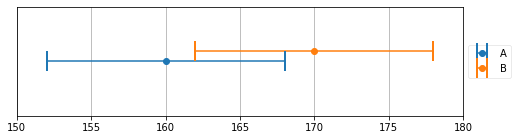

In [29]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

说说我是如何生成这个图的。我从' kf_book '子目录中导入book_plot模块 。生成这个图需要大量的Python代码，读起来并友好。我在书中经常采用这种方法。当单元格运行时，将调用' plot_errorbars() '，并将绘图插入到书中。

如果这是你第一次使用[Jupyter Notebook](http://jupyter.org/)，上面的代码是在一个*cell*中。文本“In[2]:”将此标记为可以在其中输入的单元格，方括号中的数字表示该单元格是第二个运行的。要运行单元格，请使用鼠标单击它，使其选中，然后按键盘上的CTRL+ENTER。随着我们继续，您将能够更改单元格内的代码并重新运行它们。尝试将值“160”、“170”和“8”更改为其他值并运行单元格。打印的输出应该根据您输入的内容而改变。

如果想查看plot_errorbars的代码，可以在编辑器中打开它，或者创建一个新的单元格并输入函数名，后跟两个问号。按Ctrl+Enter，您的浏览器将打开一个显示源代码的窗口。这是Jupyter Notebook的一个特点。如果您只想查看函数的文档，也可以这样做，但要打一个问号。
```Python

    plot_errorbars??
```
or
```Python
    plot_errorbars?
```
所以165磅看起来是一个合理的估计，但这里有更多的信息，我们可能可以利用。唯一可能的重量是在A和B误差区间的交点上。例如，161磅的重量是不可能的，因为B刻度不能给出170磅的读数，最大误差为8磅。同样，169磅的重量也是不可能的，因为秤A无法给出160磅的读数，最大误差为8磅。在这个例子中，唯一可能的重量在162到168磅之间。

这还不能让我们找到一个更好的权重估计，但让我们再增加一些“如果”。如果我们现在被告知A比B精确三倍呢?考虑我们上面列出的5个选项。选择A和B范围之外的数字仍然没有意义，所以我们不考虑它们。选择A作为我们的估计似乎更有说服力——毕竟，我们知道它更准确，为什么不用它来代替B呢? A和B一起能比单独只有A提高我们的认知吗?

答案是肯定的，可能与直觉相反。首先，让我们来看看A=160和B=170的相同测量值，但是A $\pm$ 3 lbs的误差，而B的误差是它的3倍，$\pm$ 9 lbs。

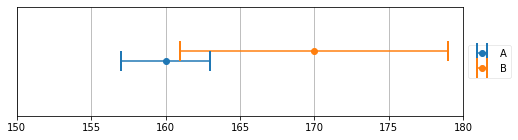

In [30]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

A的误差区间和B的重叠部分是唯一可能的真实权重。这个重叠比单独在A中的误差要小。更重要的是，在这种情况下，我们可以看到重叠不包括160磅或165磅。如果我们只使用来自A的测量，因为它比B更准确，我们会给出160磅的估计。如果我们取A和B的平均值，我们会得到165磅。这两个重量都不可能，因为我们知道天平的准确性。通过包括B的测量，我们将给出一个介于161磅和163磅之间的估计，这是两个误差区间的相交区间。

让我们来看看这个相交区间。假设我们知道A秤精确到1磅，换句话说，如果我们的真实体重是170磅，它可能报告为169磅、170磅或171磅。我们还知道B精确到9磅。我们在每个秤上称重，得到a =160, B=170。我们应该估计自己的体重是多少?让我们用图形来看看。

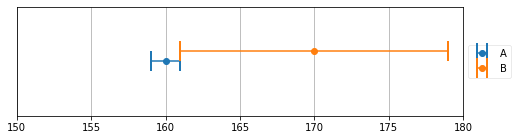

In [31]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

这里我们可以看到，唯一可能的重量是161磅。这是一个重要的结果。通过两个相对不准确的传感器，我们可以推断出一个非常准确的结果

**所以两个传感器，即使一个比另一个精度低，也比一个好。**我将在本书的其余部分详细说明这一点。我们从不丢弃信息，不管它有多么无足轻重。我们将运用数学和算法，使我们能够包括所有可能的信息来源，形成可能的最佳估计。

然而，我们偏离了我们的问题。没有客户会想买多个秤，而且，我们一开始就假设所有秤的精确度都是一样的。这种使用所有测量而不考虑精度的见解将在以后发挥重要作用，所以不要忘记它。

如果我只有一个秤，但我称了很多次呢?我们的结论是，如果我们有两个精度相同的尺度，我们应该使它们的测量结果平均。如果我用一个秤称10000次呢?我们已经说过，称同样可能返回一个过大的数字，也可能返回一个过小的数字。证明大量测量的平均值会非常接近实际值并不难，但现在让我们编写一个代码仿真。我将使用NumPy，它是[SciPy](https://scipy.org/)生态系统的一部分，用于数值计算。

In [32]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 165.0431


打印的确切数字取决于随机数生成器，但它应该非常接近165。
这段代码做了一个可能不正确的假设——当真正的重量是165磅时，秤上的读数可能是160和165。这几乎是不可能的。真正的传感器更有可能得到接近真实值的读数，而越来越不可能得到离真实值越远的读数。我们将在高斯一章详细讨论这一点。现在，我将使用' numpy.random.normal() '函数，而不做进一步解释，它将在接近165磅的地方产生更多的值，在更远的地方产生更少的值。现在请相信，这将产生与真实尺度工作方式相似的噪声测量。

In [33]:
mean = np.random.normal(165, 5, size=10000).mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 164.9923


答案还是非常接近165。

很好，我们找到了传感器问题的答案!但这不是一个非常实际的答案。没有人有耐心给自己称重一万次，甚至十几次

所以，让我们假设。如果你每天测量一次体重，得到的读数是170，161，然后是169。你是增重了，还是减重了，还是仅仅是一些杂乱的数据?

我们不能确定。第一次测量是170磅，最后一次是169磅，这意味着减掉了1磅。但如果称的精确到10磅，那就可以用噪音来解释了。我可能会增重;也许我第一天的体重是165磅，第三天是172磅。在体重增加的同时也可以得到体重读数。体重秤上显示我的体重在下降，而实际上我的体重在增加!我们来看看图表。我画出了测量值和误差区间，然后一些可能的体重增加/减少可以用这些测量值来解释

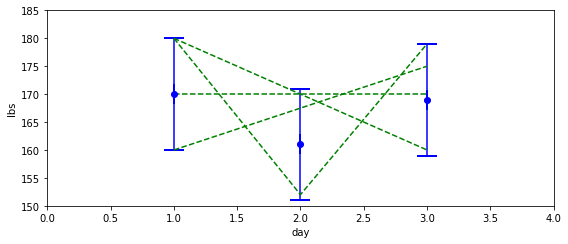

In [34]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

正如我们所看到的，体重变化的极端范围可以用这三种测量方法来解释。事实上，有无数的选择。 回想一下，我们谈论的是测量一个人的体重。一个人的体重在第一天达到180磅，在第三天达到160磅，这是不可能的。或者一天减掉30磅，第二天又长回来(我们假设患者没有截肢或其他创伤)。

我们正在测量的物理系统的行为应该影响我们如何解释测量结果。如果我们每天给一块石头称重，我们会把所有的方差都归因于噪音。如果我们称一个用于家务的雨水蓄水池的重量，我们可能会相信这种重量变化是真实的。

假设我用不同的尺度，得到以下测量值:169 170 169 171 171 169 170 169 169 170。你的直觉告诉你什么?例如，有可能你每天增重1磅，而嘈杂的测量结果恰好显示你的体重保持不变。同样的，你也可以每天减1磅，得到同样的读数。但这有可能吗?连续抛硬币得到10次正面的概率是多少?不太可能。我们不能仅凭这些读数来证明，但我的体重很有可能保持稳定。在下面的图表中，我用误差条和绿色虚线标出了可能的真实权重。这条虚线并不是这个问题的“正确”答案，只是一个合理的，可以用测量来解释的答案。

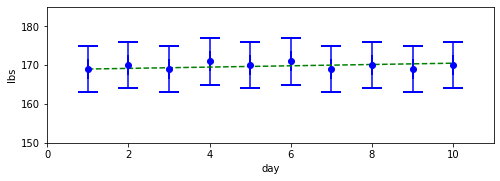

In [35]:
gh.plot_hypothesis2()

另一个假设:如果读数是158.0,164.2,160.3,159.9,162.1,164.6,169.6,167.4,166.4,171.0呢?让我们看一个图表，然后回答一些问题。

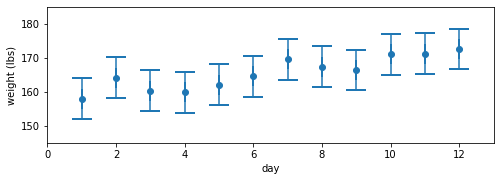

In [36]:
gh.plot_hypothesis3()

Does it 'seem' likely that I lost weight and this is just really noisy data? Not really. Does it seem likely that I held the same weight? Again, no. This data trends upwards over time; not evenly, but definitely upwards. We can't be sure, but that looks like a weight gain, and a significant weight gain at that. Let's test this assumption with some more plots. It is often easier to 'eyeball' data in a chart versus a table.
我是否“看起来”有可能减肥了，而这只是一个非常嘈杂的数据?不是真的。你觉得我的体重和你的一样吗?再一次,没有。这个数据随着时间的推移呈上升趋势;不是平均的，但肯定是上升的。我们不能确定，但这看起来像是体重增加了，而且是显著的体重增加。让我们用更多的图来检验这个假设。相比于表格，我们更容易在图表中“观察”数据。
So let's look at two hypotheses. First, let's assume our weight did not change. To get that number we agreed that we should average the measurements. Let's look at that.
我们来看两个假设。首先，假设我们的重量没有变化。为了得到这个数字，我们同意将测量值平均。我们来看看。

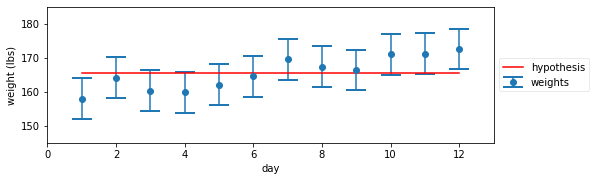

In [37]:
gh.plot_hypothesis4()

这看起来不太有说服力。事实上，我们可以看到没有水平线可以画在所有的误差区间内。

现在，我们假设体重增加了。增加了多少呢?我不知道，我们想通过测量值画一条线，看起来“大约”正确。NumPy的函数可以根据一个叫做“最小二乘拟合”的规则来做到这一点。我们不必担心计算的细节(如果您感兴趣，我使用[polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html))，只需绘制结果。

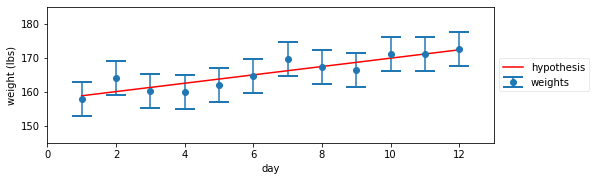

In [38]:
gh.plot_hypothesis5()


现在看起来好多了。注意现在估计值和每个测量值都很接近，而在之前的图中，估计值往往与测量值相差很远。我增重了，这似乎比我没有增重更有可能是真的。我真的长了13磅吗? 这个问题似乎无法回答。
“但是这是不可能的吗?”一位同事问。

让我们尝试假设。假设我知道我每天增加一磅。现在我是怎么知道的并不重要，假设我知道它是近似正确的。也许我每天摄入6000卡路里的饮食，会导致体重增加。或者也许有另一种方法来估计体重增加。让我们看看，如果这些信息是可用的，我们能否利用它们。

第一次测量是158。我们不知道有什么不同，所以我们接受这个估计值。如果我们今天的体重是158，明天会是多少?嗯，我们认为我们每天增加1磅体重，所以我们的预测是159磅，就像这样:

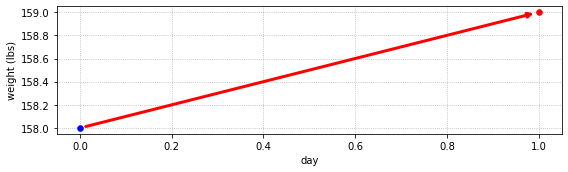

In [39]:
gh.plot_estimate_chart_1()

好吧，但这有什么好处?当然，我们可以假设1磅/天是准确的，并预测我们未来10天的体重，但如果我们不考虑称的读数，为什么要使用秤呢?让我们看看下一个测量。我们再次站在磅秤上，显示的是164.2磅。

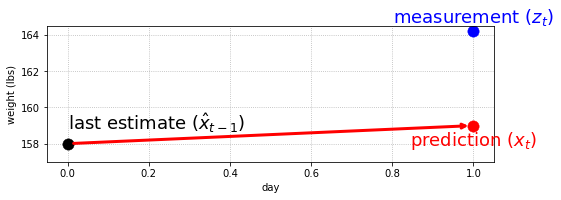

In [40]:
gh.plot_estimate_chart_2()

 
我们有麻烦了。我们的预测与测量结果不符。但这正是我们所期望的，对吧?如果预测结果总是与测量结果完全一致，那么它将无法向过滤器中添加任何信息。当然，没有理由去测量，因为我们的预测是完美的。

> **整本书的关键在下一段。仔细阅读它!**

我们该怎么做?如果我们只从测量中得出估计，那么预测将不会影响结果。如果我们只根据预测形成估计，那么测量将被忽略。如果可能的话，我们最好**将预测和测量结合**起来。

混合两个值——这听起来很像之前的两个不同精度称的问题。用同样的推理，我们可以看到，唯一有意义的事情是在预测和测量之间选择一个数字。例如，165的估计没有意义，157也没有意义。我们的估计应该在159(预测值)和164.2(测量值)之间。

再说一遍，这很重要。我们一致认为，当给出两个有误差的值时，我们应该在这两个值之间形成一个估计值。这些值是如何产生的并不重要。在本章的开始，我们有两个测量值，但现在我们有一个测量值和一个预测值。我们“从不”丢弃信息。我看到很多商业软件都抛弃了嘈杂的数据。不要这样做!我们对体重增加的预测可能不是很准确，但只要有一些信息我们就应该利用它

我必须坚持让你停下来好好想想。我所做的只是把一个不准确的体重秤换成了一个基于人体生理的不准确的体重预测。它仍然是数据。数学不知道这些数据是来不准确的体重秤还是预测。我们有两个带有一定噪声的数据，我们想把它们合并起来。在这本书的其余部分，我们将使用一些相当复杂的数学方法来执行这个计算，但数学从不关心数据来自哪里，它只根据这些值的值和准确性进行计算。

估计应该在测量和预测正中间吗？也许我们预测的准确性与尺度的准确性是不同的。回想一下，当比例A比比例B精确得多的时候我们做了什么我们将答案比例为A比B更接近A，我们来看看图表。

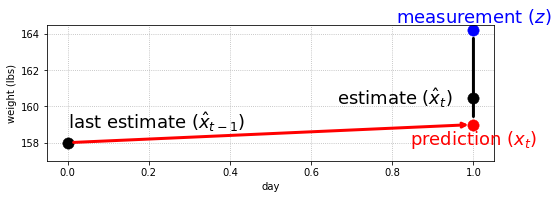

In [41]:
gh.plot_estimate_chart_3()

现在让我们尝试一个随机选择的数字来扩展我们的估计:$\frac{4}{10}$。我们的估计值将是4/10的测量值，其余的将来自预测。换句话说，我们在这里表达了一种信念，一种预测比测量更可能正确的信念。我们将其计算为

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

测量和预测之间的差异称为*残差*，用上图中的黑色垂直线表示。这将成为以后使用的一个重要值，因为它是测量值和滤波器输出之间的差值的精确计算。残差越小，性能越好。
 
让我们对其进行编码，并在测试上面的一系列权重时查看结果。我们必须考虑另一个因素。体重增加的单位是磅/时间，所以一般来说，我们需要添加一个时间步长$t$，我们将其设置为1(天)。

我手动生成了体重数据，以对应一个真正的起始体重160磅，体重每天增加1磅。换句话说，第一天(第0天)的真实重量是160磅，第二天(第一天，称重的第一天)的真实重量是161磅，以此类推。

我们需要猜测初始重量。现在谈论初始化策略还为时过早，所以现在我将假定为160磅。

In [42]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


[158.0,
 164.2,
 160.3,
 159.9,
 162.1,
 164.6,
 169.6,
 167.4,
 166.4,
 171.0,
 171.2,
 172.6]

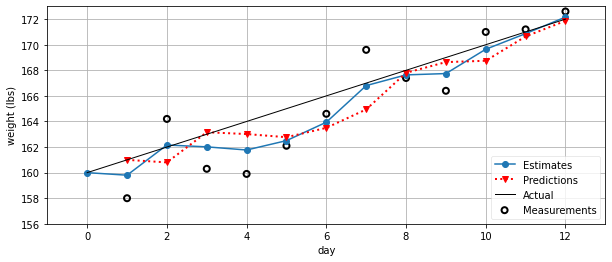

In [43]:
# plot results
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 172])
weights

看起来相当不错!这里有很多数据，我们来谈谈如何解释它。粗蓝线表示来自过滤器的估计值。从第0天开始，最初的猜测是160磅。红线表示的是根据前一天的权重做出的预测。第一天的体重是160磅，体重增加了1磅，所以第一个预测是161磅。第一天的估计值介于预测和测量之间，为159.8磅。下面的图表是打印出来的以前的体重，预测体重，和每天的新估计。最后，细黑线表示被称重者的实际体重增加。

每天执行这个步骤，确保您理解预测和估计是如何在每一步形成的。请注意，估计总是落在测量和预测之间。

估计不是一条直线，但它们比测量值更直，在某种程度上接近我们创造的趋势线。而且，随着时间的推移，它似乎会变得更好。

过滤器的效果可能会让你觉得很傻;当然，如果我们假设我们的体重增加大约是每天1磅的话，数据看起来会很好。让我们看看如果最初的猜测是错误的，过滤器会怎么做。让我们预测一下，每天减重1磅:

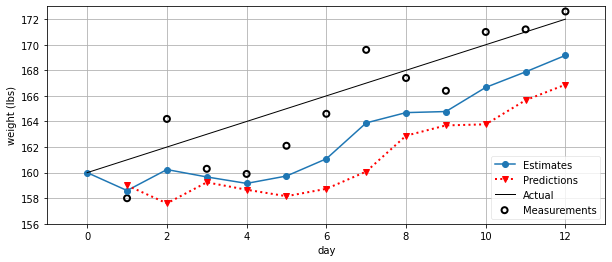

In [44]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 172])

效果并不理想。估计值很快就偏离了测量值。即使我们最初的猜测是正确的，一旦变化的速度改变，过滤器也会失效。如果我停止暴饮暴食，过滤器将很难适应这种变化。注意，它正在调整!尽管我们告诉它我们每天减1磅，但估计数字仍在攀升。它的调整速度还不够快。

但是,“如果”?如果不是让体重增加在最初的猜测1磅(或其他)，我们从现有的测量和估计计算它。第一天，我们对重量的估计是:
$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

第二天我们测量值为164.2磅，这意味着体重增加了4.4磅(因为164.2 - 159.8 = 4.4)，而不是1磅。我们能利用这些信息吗?这似乎是可信的。毕竟，体重测量本身是基于真实世界对我们体重的测量，所以有有用的信息。我们对体重增加的估计可能并不完美，但这肯定比仅仅猜测体重增加1磅要好。数据总比猜测好，即使它是有噪声的。

人们在这一点上真的很犹豫，所以要确保你们都同意。对体重的两个干扰测量给出了一个隐含的体重增加/减少。如果测量不准确，估计就会非常不准确，但计算中仍然有信息。想象一下，用一个精确到1磅的秤称一头牛，结果显示这头牛长了10磅。这头牛可能增加了8磅到12磅，这取决于误差，但我们知道它增加了体重，大致是多少。这是信息。我们如何处理信息?不要把它扔掉!

回到饮食这个例子上来。我们应该把每天的新增体重设定为4.4磅吗?昨天我们认为体重增加了1磅，今天我们认为是4.4磅。我们有两个数，想把它们结合起来。看来又是我们的问题了。我们用同样的工具，也是目前唯一的工具，在两者之间选一个值。这次我将使用另一个任意选择的数字，$\frac{1}{3}$。这个方程和体重估计的方程是一样的，除了我们必须考虑时间，因为这是一个速率(增加/天):
$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

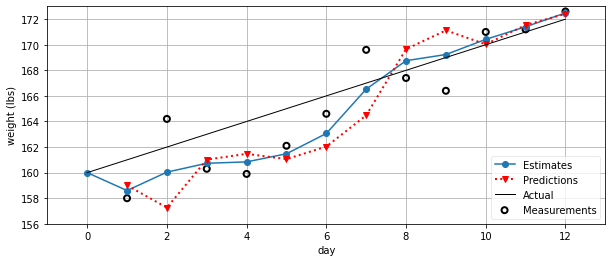

In [45]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 172])

我觉得现在看起来不错了。由于体重增加的初始估计值为-1，所以过滤器需要几天的时间才能准确预测体重，但一旦预测成功，它就会开始准确跟踪体重。我们没有使用任何方法来选择$\frac{4}{10}$和$\frac{1}{3}$的比例因子(实际上，对于这个问题，它们并不是很好的选择)，但除此之外，所有的数学都是基于非常合理的假设。回想一下，您可以将参数' time_step '的值更改为更大的值，并重新运行单元格(如果您希望逐步查看绘制的图)。

在我们继续之前，还有最后一点。在预测步骤中，我写了这一行
```python
gain_rate = gain_rate
``` 
这显然没有效果，可以删除。我写这篇文章是为了强调在预测步骤中你需要预测所有变量的下一个值，包括‘weight’和‘gain_rate’。这将很快变得相关。在这种情况下，我们假设增益不变化，但当我们推广这个算法时，我们将去掉这个假设。

##  g-h 滤波器

这个算法被称为[g-h滤波器](https://en.wikipedia.org/wiki/Alpha_beta_filter)或$\alpha$-$\beta$滤波器。$g$和$h$是我们在示例中使用的两个缩放因子。$g$是我们用于测量的刻度(在我们的例子中是重量)，$h$是测量随时间变化的刻度(在我们的例子中是磅/天)。$\alpha$和$\beta$只是这个因子的不同名称。

这个滤波器是许多滤波器的基础，包括卡尔曼滤波器。换句话说，卡尔曼滤波器是g-h滤波器的一种形式，我将在书的后面证明它。最小二乘滤波器也是，你们可能听说过，本尼迪克特-博德纳(Benedict-Bordner)滤波器也是，你们可能没听说过。每个滤波器都有不同的方法给$g$和$h$赋值，但其他的算法是相同的。例如，Benedict-Bordner滤波器将常数赋给$g$和$h$，限定在一定范围内的值。其他过滤器，如卡尔曼将改变$g$和$h$  

**让我重复一下要点，因为它们很重要**。如果你不理解这些，你就不会理解这本书的其余部分。如果你真的理解了它们，那么这本书的其余部分将自然地为你展开，就像我们将问的关于$g$和$h$的各种“如果”问题的数学阐述。数学可能看起来完全不同，但算法是完全一样的。

*多个数据比一个数据更准确，所以无论多么不准确，都不要丢弃任何东西。

*总是在两个数据之间选择一个数字来创建一个更准确的估计。

*根据目前的估计和我们认为它将会改变的程度，预测下一次的测量和变化率。

*然后选择新的估计作为预测和下一次测量之间的一部分，根据每一次测量的准确性进行衡量。

让我们看一下算法的可视化描述。

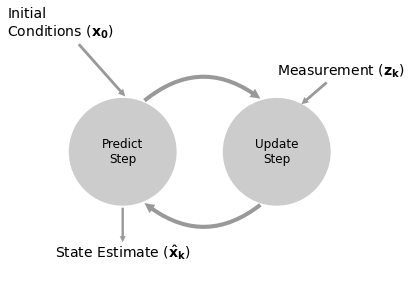

In [46]:
book_plots.predict_update_chart()

让我介绍一些更正式的术语。系统是我们想要估计的对象。在本章中，系统是我们试图衡量的任何东西。一些文章称它为“plant”。这个术语来自控制系统理论。https://en.wikipedia.org/wiki/Plant_ (control_theory)
 
系统的“状态”是我们感兴趣的系统的当前配置或值。我们只对重量读数感兴趣。如果我把一个100公斤的重量放在秤上，状态是100公斤。我们根据与我们相关的东西来定义状态。颜色与我们不关心，所以我们在状态中不包括那些值。制造商的质量保证工程师可能会在状态中包括颜色，这样她就可以跟踪和控制生产过程。

*测量值*是系统的测量值。测量可能是不准确的，因此它可能与状态值不同。

*状态估计*是我们的过滤器对状态的估计。例如，对于100公斤的重量，由于传感器误差，我们的估计可能是99.327公斤。这通常被缩写为*estimate*，我已经在本章中完成了。
 
换句话说，状态应该被认为是系统的真实值。这个值通常对我们是“隐藏的”。如果我站在秤上，你就会有一个“测量”。我们称它为“可观察的”，因为你可以直接观察到这个测量值。相反，你不能直接观察我的体重，你只能测量它。

这种“隐藏的”和“可观察的”描述很重要。任何估计问题都包括通过可观测测量来形成一个隐藏状态的估计。如果你阅读了相关文献，你就会发现在定义问题时使用了这些术语，所以你需要适应它们。

我们使用“动力模型”来对系统进行数学建模。在本章中，我们的动力模型是假设我今天的体重是昨天的体重加上我最后一天增加的体重。 另一个例子是汽车 。动力模型可能是“距离等于速度乘以时间”。这个模型并不完美，因为汽车的速度可能在一段非零的时间内变化，轮胎可能在路上打滑，等等。*系统误差*或*测量误差*是这个模型中的误差。我们永远不知道这个值; 
 
预测的步骤称为“系统传播”。它使用*过程模型*来形成一个新的*状态估计*。由于*过程误差*，这个估计是不完美的。假设我们在一段时间内跟踪数据，我们说我们将状态“传播”到未来。 
 
更新步骤称为*测量更新*。系统传播和测量更新的一个迭代被称为“epoch”。

现在让我们探索几个不同的问题领域，以更好地理解这个算法。考虑一下在轨道上追踪火车的问题。轨道把火车的位置限制在一个特定的区域内。此外，火车又大又慢。它们需要很多分钟才能明显减速或加速。所以，如果我知道火车在时间t时在23公里处以18公里每小时的速度移动，我就可以非常自信地预测它在时间t + 1秒的位置。为什么这很重要?假设我们只能以250米的精度测量它的位置。火车以18千米每小时的速度行驶，也就是5米每秒。在t+1秒时，列车将达到23.005公里，但测量值可能从22.755公里到23.255公里不等。因此，如果下一次测量说位置是23.4，我们知道那一定是不准确的。即使在工程师猛踩刹车的时候，火车仍然会非常接近23.005公里，因为火车不可能在1秒内减速很多。如果我们要为这个问题设计一个过滤器(我们将在本章进一步讨论)，我们就需要设计一个给予预测相对于测量非常高的权重的过滤器。

现在考虑跟踪一个投掷的球的问题。我们知道弹道物体在真空中在重力场中以抛物线运动。但是扔在地球上的球会受到空气阻力的影响，所以它不会以完美的抛物线运动。棒球投手在投曲线球时就会利用这一点。假设我们正在用计算机视觉追踪体育场里的球，这是我在工作时做的。计算机视觉跟踪的准确性可能不高，但通过假设球沿抛物线运动来预测球的未来位置也不是非常准确。在这种情况下，我们可能会设计一个过滤器，让测量和预测的权重大致相等。 

现在考虑一下在飓风中追踪氦气球。我们没有合法的模型可以让我们预测气球的行为，除了在非常短的时间尺度(例如，我们知道气球不能在1秒内跑10英里)。在这种情况下，我们将设计一个过滤器，强调测量而不是预测。

本书的大部分内容都是用数学的方法来表达最后三段的关注点，这样我们就可以找到一个最优的解决方案(在某种数学意义上)。在这一章中，我们将仅仅以一种更直观的方式给$g$和$h$赋不同的值，因此不是最优的方法。但其基本思想是将有些不准确的测量和有些不准确的系统行为模型混合起来，以得到一个过滤后的估计，这比任何一个信息源本身都要好。

我们可以用算法来表示:
**初始化**

    1. 初始化滤波器的状态
    2. 在状态中初始化我们的信念

**预测**

    1. 使用系统行为来预测下一个时刻的状态
    2. 调整预测中的不确定度
    
**更新**

    1. 得到一个测量值 并计算不确定度
    2. 计算估计状态和测量之间的残差
    3. 新的估计在剩余线上的某个地方
    
我们将在整本书中使用相同的算法，尽管有一些修改。

## 符号

我将开始介绍文献中使用的符号和变量名。上面的图表中已经使用了其中的一些。测量值通常用$z$表示，这就是我们在本书中将使用的(一些文献使用$y$)。下标$k$表示时间步长，所以$z_k$是这个时间步长的数据。粗体表示向量或矩阵。到目前为止，我们只考虑有一个传感器，因此只有一个传感器测量，但一般来说，我们可能有*n*个传感器和*n*个测量。$\mathbf{x}$表示我们的状态，并以粗体表示它是一个向量。对于我们的体重秤例子，它代表了初始体重和初始体重增加率，如下所示:
$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

这里我用牛顿的点除以x来表示速度。更准确地说，点表示x对时间的导数，当然就是速度。体重62公斤，每天增加0.3公斤

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

所以，算法很简单。状态初始化为$\mathbf{x_0}$，即初始估计值。然后我们进入一个循环，根据time(或step) $k-1$的值预测time或step $k$的状态。然后我们得到度量值$z_k$，并在度量值和预测值之间选择某个中间点，创建估计值$\mathbf{x}_k$。

## 练习:编写一般类型算法

在上面的例子中，我明确地编写了这个代码以解决我们在整个章节中一直在讨论的称重问题。例如，变量被命名为“weight_scale”、“gain”等等。我这样做是为了让算法易于遵循-你可以很容易地看到我们正确地实现了每个步骤。但是，这是只针对一个问题编写的代码，对于任何问题，算法都是一样的。因此，让我们重写代码，使其具有通用性——以处理任何问题。使用此功能签名:
```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    对一个g和h固定的状态变量执行g-h过滤器。

    'data' 包含要过滤的数据。
    'x0'  状态变量的初始值
    'dx'  状态变量的微分
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

以NumPy数组而不是列表的形式返回数据。通过传递与之前相同的权重数据来测试它，绘制结果，并直观地确定它是否有效。

In [47]:
from kf_book.gh_internal import plot_g_h_results
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  your solution here

# uncomment to run the filter and plot the results
#book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
#data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
#plot_g_h_results(weights, data)

### 解决方案和讨论

[158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
[159.2   161.8   162.1   160.78  160.985 163.311 168.1   169.696
 168.204 169.164 170.892 172.629]


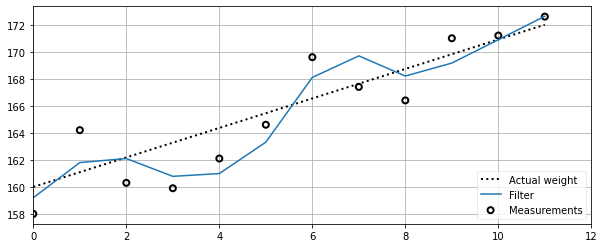

In [48]:
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)
print(weights)
print(data)

这应该很简单。我只是将变量名' x0 '， ' dx '等替换为权重增加代码中的变量名。没有什么需要改变的

## 选择 $g$ 和 $h$

g-h滤波器不是一个滤波器-它是一组滤波器的分类。Eli Brookner在*Tracking and Kalman Filtering Made Easy*中列出了11个，我相信还有更多。不仅如此，每种类型的过滤器都有许多子类型。每个过滤器的区别在于$g$和$h$的选择方式。所以我在这里没有“一刀切”的建议。有些过滤器设置$g$和$h$为常量，有些则动态地改变它们。卡尔曼滤波器在每一步都动态地改变它们。一些过滤器允许$g$和$h$接受范围内的任何值，其他过滤器通过函数$f(\dot{})， \mbox{where}g = f(h)$约束其中一个依赖于另一个。

这本书的主题不是整个g-h滤波器家族;更重要的是，我们对这些过滤器的*贝叶斯*方面感兴趣，这一点我还没有谈到。因此，我将不再深入讨论$g$和$h$的选择。*Tracking and Kalman Filtering Made Easy*是一个很好的资源。如果你觉得我采取这种立场很奇怪，请认识到卡尔曼滤波器的典型公式根本不使用$g$和$h$。卡尔曼滤波器是g-h滤波器，因为它在数学上简化为这种算法。当我们设计卡尔曼滤波器时，我们使用的设计标准可以在数学上简化为$g$和$h$，但卡尔曼滤波器形式通常是一个更强大的方式来思考这个问题。如果现在还不清楚，不要担心，一旦我们学习了卡尔曼滤波理论，就会清楚了。

我们有必要看看不同的$g$和$h$是如何影响结果的，所以我们将通过一些示例进行工作。这将使我们深入了解这类滤波器的基本优点和局限性，并帮助我们理解更为复杂的卡尔曼滤波器的行为。

## 练习:创建测量方程

现在我们来写一个函数，它会产生噪声数据。在这本书中，我将噪声信号建模为信号加上[白噪声](https://en.wikipedia.org/wiki/White_noise)。我们还没有涵盖统计数据来完全理解白噪声的定义。从本质上说，它是一种数据，随机地比信号高或低变化，没有模式。我们说它是一个均值为零，方差有限的序列不相关随机变量。如果你不明白，在*高斯函数*那一章的结尾你就会明白了。如果你没有统计学的知识，你可能无法成功地完成这个练习。如果是这样，请阅读解决方案并进行讨论。

白噪声可以由' numpy.random.randn() '生成。我们希望调用的函数具有初始值、每步的变化量、步数和我们想要添加的噪声量。它应该返回一个数据列表。通过创建30个点来测试它，使用' g_h_filter() '过滤它，并使用' plot_g_h_results() '绘制结果

In [49]:
# your code here

### Solution

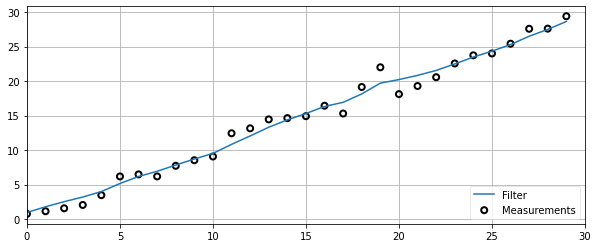

In [50]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### 讨论
 
' randn() '返回以0为中心的随机数-它可能大于0，也可能小于0。它的变化是*一个标准差*，如果你不知道这是什么意思，别担心。我已经绘制了3000个对' randn() '的调用-你可以看到值以0为中心，大部分范围从-1以下一点到+1以上一点，尽管偶尔它们会大得多。

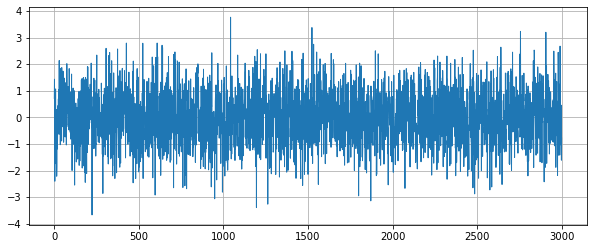

In [51]:
plt.plot([randn() for _ in range(3000)], lw=1);

## 练习:糟糕的初始条件

现在编写代码，使用' gen_data '和' g_h_filter '过滤100个数据点，这些数据点从5开始，导数为2，噪声比例因子为10，并使用g=0.2和h=0.02。假设x的初始值是100。

In [52]:
# your code here

### 解决方案和讨论

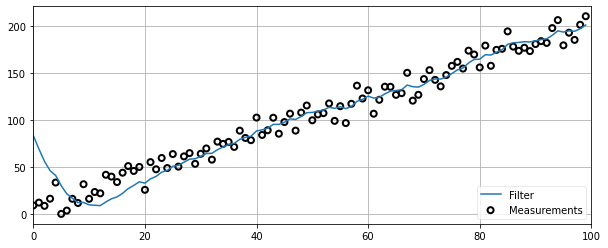

In [53]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

滤波器开始时的估计值与测量数据相差甚远，因为最初的估计值为100。你可以看到，它在测量数据之前就开始‘环状’了。”“Ringing”的意思是信号在正弦模式中，数据的过冲和欠冲。这在滤波器中是一个非常普遍的现象，在滤波器设计中，很多工作都致力于最小化Ringing。这是一个我们还没有准备好讨论的话题，但我想向你们展示一个现象。

## 练习:极端的噪声

Rerun the same test, but this time use a noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.
重新运行相同的测试，但这次使用的噪声系数为100。通过将初始条件从100降低到5来消除初始条件ringing 。

In [54]:
# your code here

### 解决方案和讨论

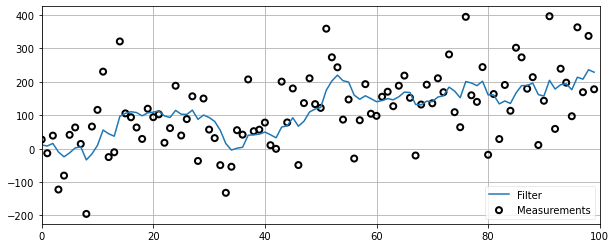

In [55]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

在我看来，这可不太妙。我们可以看到，也许过滤后的信号变化小于噪声信号，但它远非直线。如果我们只绘制过滤后的结果，没有人会猜出信号从5开始，每一步递增2。虽然在某些地方，过滤器似乎确实减少了噪声，但在其他地方，它似乎超调和欠调。

在这一点上，我们所知道的还不足以做出真正的判断。我们添加了许多噪音;也许这是最好的过滤。然而，在这一章节之外的众多章节的存在应该表明我们可以做得更好。

## 练习:加速的效果

 编写一个新的数据生成函数，为每个数据点添加一个恒定的加速因子。换句话说，当你计算每个数据点时，增加dx，这样速度(dx)就会不断增加。将噪声设置为0，$g=0.2$和$h=0.02$，并使用' plot_g_h_results '或您自己的例程绘制结果。尝试不同的加速和计时步骤。解释你所看到的

In [56]:
# your code here

### 解决方案和讨论

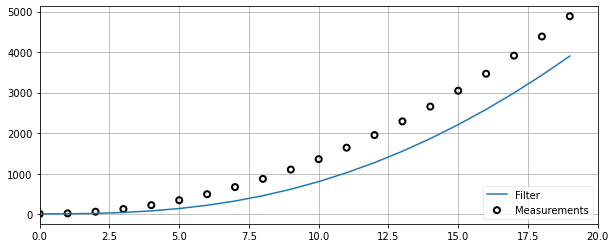

In [57]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + accel * (i**2) / 2 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=9.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

每个预测都滞后于信号。如果你想想发生了什么，这是有道理的。我们的模型假设速度是恒定的。g-h滤波器计算$x$的一阶导数(我们用$\dot{x}$来表示导数)，但不计算$\ddot{x}$的二阶导数。假设$\ddot{x}=0$。在每个预测步骤中，我们将x的新值预测为$x + \dot{x}*t$。但由于加速度的存在，预测结果必然落后于实际值。然后我们尝试为$\。{x}$计算一个新的值，但是由于$h$因素，我们只部分地调整$\。在下一个迭代中，我们将再次失败。

注意，我们无法对$g$或$h$进行调整来纠正这个问题。这被称为系统的“滞后误差”或“系统误差”。这是g-h滤波器的基本性质。也许你的头脑已经为这个问题提出了解决方案或变通方案。正如你所预料的，很多研究都致力于这个问题，我们将在这本书中提出解决这个问题的各种方法。
>最重要的一点是，滤波器只和用来表达系统的数学模型一样好。

## 练习: 改变 $g$

 现在让我们看看改变$g$的效果。在执行此练习之前，请记住$g$是在度量和预测之间进行选择的比例因子。你认为$g$值大会有什么影响?一个小的价值?

现在，让' noise_factor=50 '和' dx=5 '。绘制$g = 0.1\mbox{，} 0.4，\mbox{和}0.8$的结果。

In [58]:
# your code here

### 解决方案和讨论

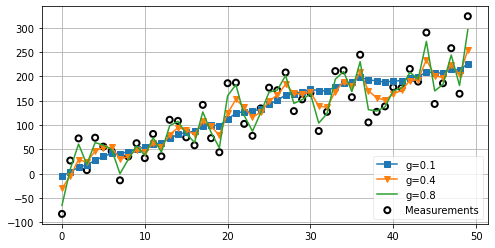

In [59]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)

很明显，由于$g$更大，我们更接近测量而不是预测。当$g=0.8$时，我们几乎完全跟踪信号，几乎不排斥任何噪声。有人可能会天真地得出结论，$g$应该总是很小，以最大限度地抑制噪声。然而，这意味着我们基本上忽略了有利于我们预测的测量值。当信号的变化不是由于噪声，而是由于实际状态的变化时，会发生什么?让我们看一看。在更改为$\。{x}=0$之前，我将创建具有$\。dot{x}=1$的9步数据。

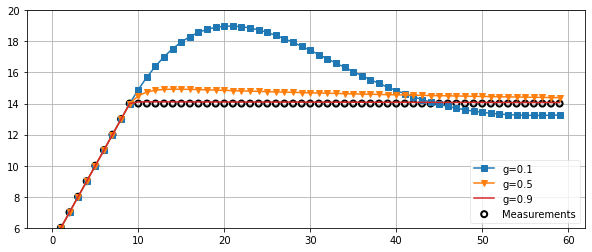

In [60]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

这里我们可以看到忽略信号的效果。我们不仅滤除噪声，还滤除信号中合理的变化。

也许我们需要一个“Goldilocks”过滤器，其中$g$不是太大，也不是太小，而是刚刚好?嗯,不完全是。正如前面提到的，不同的过滤器根据问题的数学性质以不同的方式选择$g$和$h$。例如，本例中，本尼迪克特-博尔德纳（Benedict-Bordner）滤波器被发明来最小化瞬态误差，其中$\dot{x}$进行了一步跳转。我们将不在本书中讨论这个过滤器，但是这里有两个不同允许的$g$和$h$的图。这种滤波器设计使$\dot{x}$中阶跃的瞬态误差最小化，代价是$\dot{x}$中其他类型的变化不是最优的。

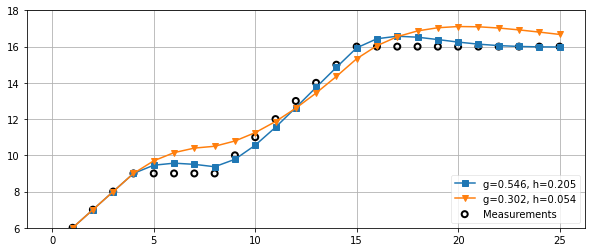

In [61]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## 改变 $h$

现在让我们保持$g$不变，并研究修改$h$的效果。我们知道$h$影响我们对$\dot{x}$与我们的预测的测量的偏好程度。但这“意味着什么”呢?如果我们的信号变化很大(相对于滤波器的时间步长很快)，那么一个较大的$h$将导致我们对这些瞬时变化迅速作出反应。一个较小的$h$将导致我们反应更慢。

我们将看三个例子。我们有一个的测量，从0缓慢地到1，使用50步的步数。我们的第一个过滤器使用了一个几乎正确的初始值$\。{x}$和一个小的$h$。你可以从输出看到滤波器的输出非常接近信号。第二个过滤器使用非常错误的猜测$\dot{x}=2$。在这里，我们看到滤波器“振动”，直到它稳定下来并找到信号。第三个过滤器使用相同的条件，但它现在设置$h=0.5$。如果你观察振动的振幅，你会发现它比第二张图小得多，但频率却大得多。它也比第二种滤镜更快地安定下来，虽然不是很多。

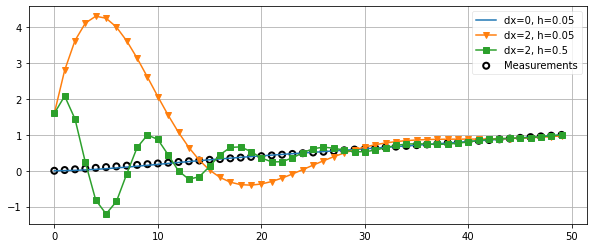

In [62]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## 互动的例子

对于那些在Jupyter Notebook中运行这个程序的人，我已经编写了一个交互式的过滤器版本，这样你就可以看到实时更改$\。{x}$， $g$和$h$的效果。当你为$\。{x}$， $g$和$h$调整滑块时，数据将被重新过滤，并为你绘制结果。

如果你真的想测试自己，阅读下一段，并在移动滑块之前预测结果。
 
需要尝试的事情包括将$g$和$h$设置为最小值。看看这个过滤器是多么完美地跟踪数据!这只是因为我们完美地预测了体重的增加。调整$\。{x}$大于或小于5。过滤器应该偏离数据，并且永远不会重新获取它。开始添加回$g$或$h$，看看过滤器如何捕捉回数据。看看这一行中只添加$g$和只添加$h$的区别。你能解释一下造成这种差异的原因吗?然后尝试设置$g$大于1。你能解释一下结果吗?把$g$放回一个合理的值(比如0.1)，然后把$h$变得非常大。你能解释一下这些结果吗?最后，将$g$和$h$设置为最大值。

如果您想对此进行更多的研究，请将数组' zs '的值更改为上面任何图表中使用的值，并重新运行单元格以查看结果。

In [63]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

## 不要对过滤器撒谎

你可以自由设置$g$和$h$为任何值。这是一个在极端噪声下表现完美的过滤器。

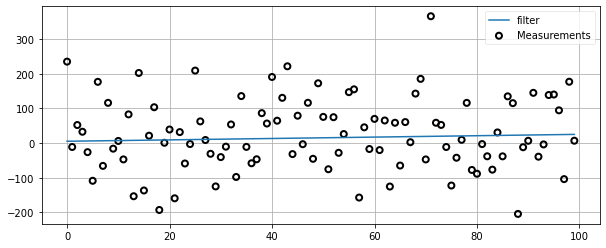

In [64]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

我出色地从非常嘈杂的数据中提取出了一条直线!也许我现在还不应该去拿我的菲尔兹数学奖。我通过将$g$和$h$设置为0来做到这一点。这是干什么用的?它使过滤器忽略测量值，因此每次更新时，它计算新的位置为$x + \Delta x \Delta t$。当然，如果我们忽略测量值，结果是一条直线。

忽略测量值的过滤器是没用的。我知道你永远不会把$g$和$h$都设为零，因为这需要一种只有我才有的特殊天赋，但我保证，如果你不小心，你会把它们设得比应该的低。你总是可以从测试数据中得到很好的结果。当您在不同的数据上尝试筛选时，您会对结果感到失望，因为您为特定的数据集精心调整了常数。$g$和$h$必须反映您所过滤的系统的真实行为，而不是一个特定数据集的行为。在后面的章节中，我们将学习很多关于如何做到这一点的知识。现在我只能说要小心，否则你的测试数据将得到完美的结果，但一旦你切换到真实数据，结果就像这样:

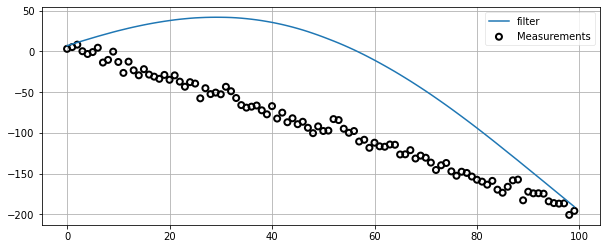

In [65]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## 跟踪一辆火车

我们准备举一个实际的例子。在本章的前面，我们讨论了跟踪一列火车。火车又重又慢，因此不能快速改变速度。他们在一个轨道上，所以他们不能改变方向，除非通过减速到停止，然后逆转路线。因此，我们可以得出结论，如果我们已经知道列车的近似位置和速度，那么我们可以很准确地预测它在不久的将来的位置。火车不可能在一两秒钟内改变它的速度太多。

我们来写一个列车的过滤器。它的位置表示为它在轨道上相对于某个固定点的位置，我们说固定点是0km。即，位置为1表示列车距离定点1公里。速度表示为米每秒。我们每秒测量一次位置，误差为$\pm$ 500米。我们应该如何实现过滤器?

我们来写一个列车的过滤器。它的位置表示为它在轨道上相对于某个固定点的位置，我们说固定点是0km。即，位置为1表示列车距离定点1公里。速度表示为米每秒。我们每秒测量一次位置，误差为$\pm$ 500米。我们应该如何实现过滤器?

首先，让我们模拟没有过滤器的情况。我们假设火车现在的速度是23公里，速度是15米/秒。我们可以把它写成

```python
pos = 23*1000
vel = 15
```
现在我们可以计算火车在未来某一时刻的位置，假设速度不变
```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```
我们可以通过在位置上加入一些随机噪声来模拟测量。这里我们的误差是500米，所以代码可能是这样的:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
让我们把它放在一个单元格中，并绘制100秒模拟的结果。我将使用NumPy的' asarray '函数将数据转换为一个NumPy数组。这将允许我使用'/'操作符一次除数组中的所有元素。

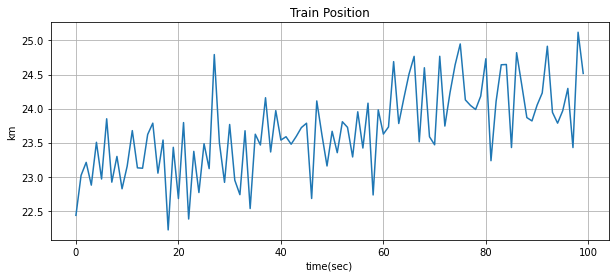

In [66]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

从图表中我们可以看出测量结果有多差。真正的火车是不会这样跑的。

那么，如果我们想过滤这个数据，我们应该设置$g$和$h$，为什么呢?我们还没有对此提出理论，但让我们凭感觉设法得到一个合理的答案。我们知道测量是非常不准确的，所以我们不想给他们太多的权重。要做到这一点，我们需要选择一个非常小的$g$。我们也知道火车不能快速加速或减速，所以我们也想要很小的$h$。例如:

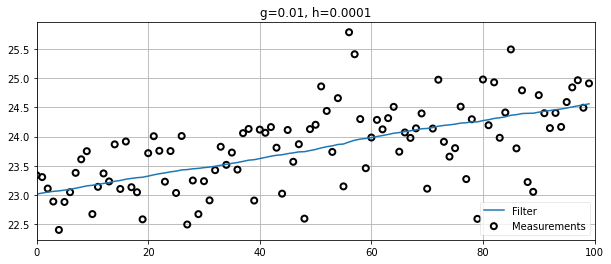

In [67]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

这是一个很好的初步猜测。让我们将$g$放大，看看效果如何。

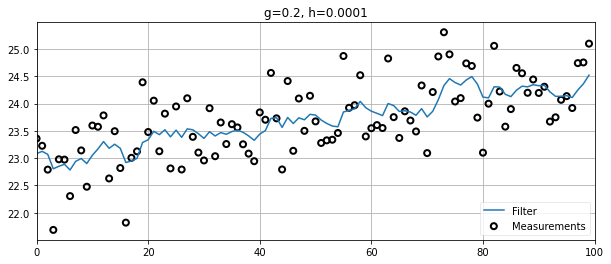

In [68]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

我们让`g=0.2`，我们可以看到，当火车的位置被平滑时，估计的位置(以及速度)在一个非常小的框架内波动很大，远比真实的火车所能做的要多。根据经验，我们知道我们想要`g<<0.2`。

现在让我们看看一个糟糕的选择对$h$的影响。

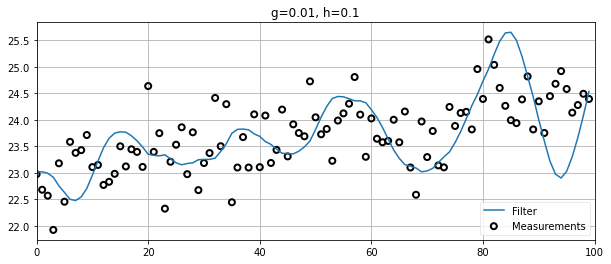

In [69]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

在这里，由于$g$很小，位置变化平稳，但是大$h$使滤波器对测量结果非常敏感。这是因为在几秒钟内，快速变化的测量意味着一个非常大的速度变化，一个大的$h$告诉过滤器对这些变化做出快速反应。火车不能快速改变速度，所以过滤器不能很好地过滤数据——过滤器改变速度的速度比火车快。

最后，让我们给火车增加一些加速度。我不知道火车能加速多快，我们设加速度是0.2米/秒^2。

In [70]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

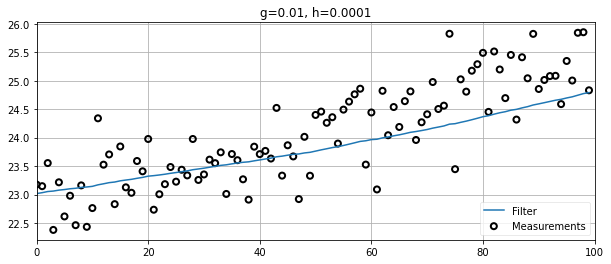

In [71]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

这里我们看到，由于加速度，滤波器不再完全跟踪列车。我们可以摆弄$h$，让它更好地跟踪，但代价是不太平滑的过滤估计。

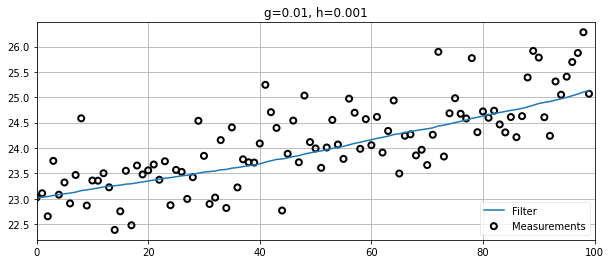

In [72]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

这里有两个教训要吸取。首先，使用$h$术语来响应您没有建模的速度变化。但是，更重要的是，在快速准确地对行为变化做出反应和在系统处于稳定状态时产生理想的输出之间有一个权衡。如果火车不改变速度，我们将$h$设置为极小值，以避免过滤后的估计不恰当地受到测量噪声的影响。但在一个有趣的问题中，状态几乎总是在变化，我们想要快速地对它们做出反应。我们对它们的反应越快，就越容易受到传感器噪音的影响。
 
我还可以继续，但我的目标不是在这里发展g-h过滤理论，而是深入了解如何结合测量和预测得出过滤后的解决方案。有很多关于如何选择$g$和$h$来解决这类问题的文献，并且有选择它们来实现各种目标的最佳方法。正如我之前所解释的，在使用这样的测试数据进行实验时，很容易对过滤器“撒谎”。在接下来的章节中，我们将学习卡尔曼滤波器如何以同样的基本方式解决这个问题，但要使用复杂得多的数学。

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy)是我写的一个开源过滤库。它有这本书中所有的过滤器，还有其他的。编写自己的g-h过滤器是相当容易的，但随着我们的进展，我们将更多地依赖FilterPy。作为一个快速的介绍，让我们看看FilterPy中的g-h过滤器。
 
如果您没有安装FilterPy，只需从命令行发出以下命令。

    pip install filterpy
    
阅读附录A了解更多关于从GitHub安装或下载FilterPy的信息。要使用g-h过滤器，请导入它并从类' GHFilter '中创建一个对象。 

In [73]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

当你构造对象时，你指定了信号(' x'和'dx')的初始值和变化率，更新(' dt ')和两个滤波器参数(' g '和' h ')之间的时间步长。dx的单位必须是x / dt，如果x的单位是米，dt的单位是秒，那么dx的单位一定是米每秒。

要运行筛选器调用update，需要在参数' z '中传递度量值，您应该记得，这是文献中度量值的标准名称。

In [74]:
f.update(z=1.2)

(0.96, 0.24)

' update() '返回元组中' x '和' dx '的新值，但你也可以从对象中访问它们。

In [75]:
print(f.x, f.dx)

0.96 0.24


你可以动态地改变“g”和“h”。

In [76]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


您可以在批处理中过滤一系列测量。

In [77]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


您可以过滤多个独立变量。如果你要跟踪一架飞机，你需要在3D空间中跟踪它。对' x '， ' dx '和度量值使用NumPy数组。

In [78]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


类' GHFilterOrder '允许你创建顺序为0、1或2的过滤器。g-h滤波器是1阶的。我们还没讲过的g-h-k滤波器，也能跟踪加速度。这两个类都具有实际应用程序所需的功能，例如计算方差减少因子(Variance Reduction Factor, VRF)，这在本章中还没有讨论。关于g-h滤波器的理论和应用，我可以写一本书，但在这本书中我们还有其他目标。如果您感兴趣，可以探索FilterPy代码并进一步阅读。

FilterPy的文档在https://filterpy.readthedocs.org/。

## 总结

我鼓励您尝试一下这个过滤器，以了解它的反应。我们不应该进行太多的尝试来认识到𝑔和ℎ的特别选择并不能很好地执行。一个特定的选择可能在一种情况下表现良好，但在另一种情况下却非常糟糕。即使你了解𝑔和ℎ的影响，也很难选择合适的值。事实上，为𝑔和ℎ选择对于任何给定问题都是最优值是极不可能的。过滤器是设计的，不是*临时*选择的。

在某些方面，我不想在这里结束这一章，因为关于选择$g$和$h$，我们可以说很多。但是这种形式的g-h过滤器并不是本书的目的。设计卡尔曼滤波器需要你指定一些参数-间接地，它们与选择$g$和$h$有关，但当你设计卡尔曼滤波器时，你永远不会直接引用它们。此外，$g$和$h$在每个时间步骤都会以一种非常不明显的方式发生变化。

这些过滤器还有另一个我们几乎没有触及的特性——贝叶斯统计。你会注意到“贝叶斯”这个术语在这本书的标题中;这不是巧合!目前，我们将把$g$和$h$留在后面，很大程度上未被探索，并发展一个关于过滤的非常强大的概率推理形式。然而，突然之间，同样的g-h滤波算法将出现，这一次，它有一个正式的数学大厦，允许我们从多个传感器创建过滤器，以准确估计我们的解决方案中的误差量，并控制机器人。